In [1]:
!pip install sklearn-quantile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Dataset

In [3]:
# Membaca file CSV
df = pd.read_csv('/content/CarPrice_Assignment.csv')

In [4]:
# Menampilkan baris awal dataset
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Exploratory Data Analysis (EDA)

In [5]:
# Informasi dasar dataset
print("Info Dataset:")
df.info()

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null

In [6]:
# Statistik deskriptif
print("Statistik Deskriptif:")
print(df.describe())

Statistik Deskriptif:
           car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204  

In [7]:
# Jumlah nilai kosong per kolom
print("Cek Missing Values:")
print(df.isnull().sum())

Cek Missing Values:
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


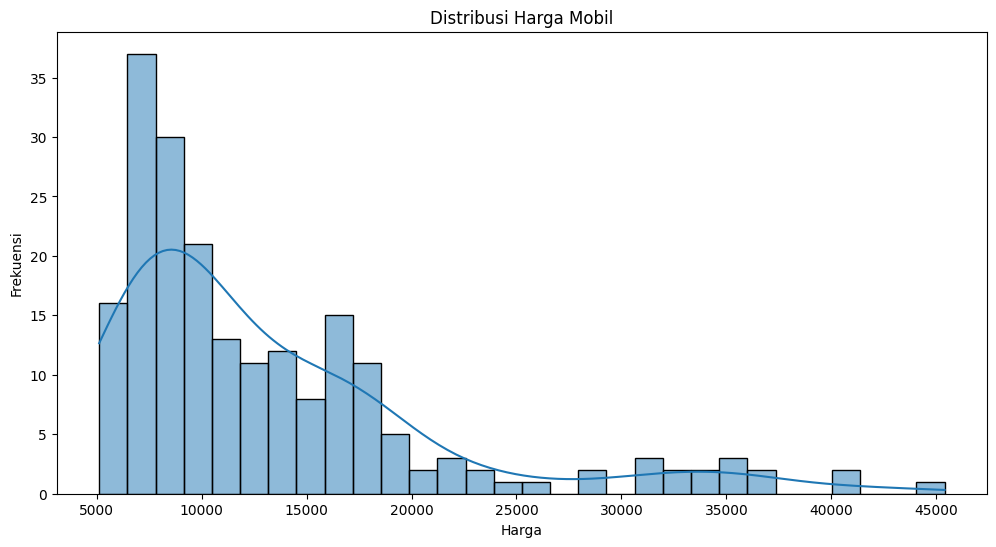

In [8]:
# Visualisasi distribusi harga mobil
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Distribusi Harga Mobil")
plt.xlabel("Harga")
plt.ylabel("Frekuensi")
plt.show()

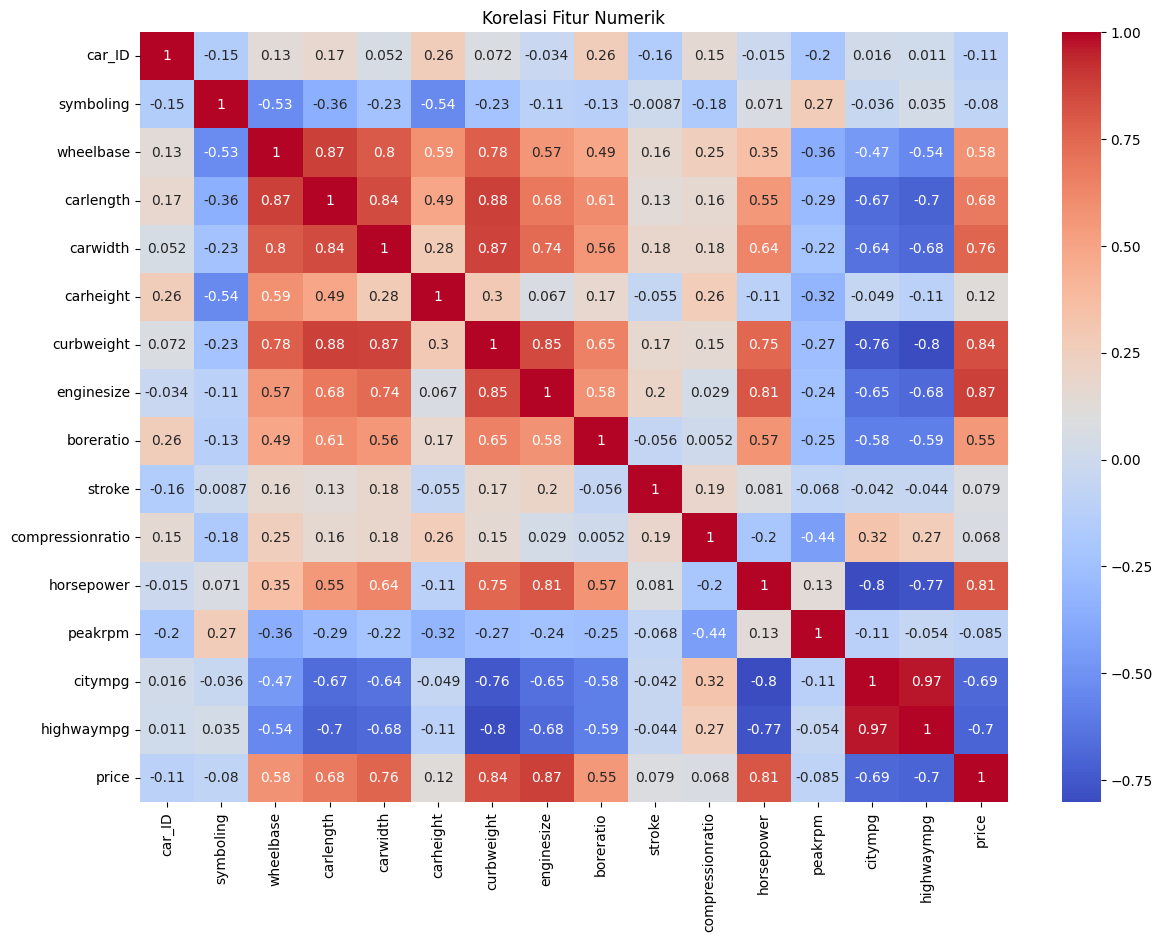

In [9]:
# Korelasi fitur numerik
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi Fitur Numerik")
plt.show()

# Preprocessing

In [10]:
# Drop kolom tidak berguna
df = df.drop(columns=['car_ID', 'symboling'])

In [11]:
# Normalisasi CarName
df['CarName'] = df['CarName'].str.lower()

In [12]:
# Ambil brand dari CarName
df['brand'] = df['CarName'].apply(lambda x: x.split(' ')[0])
df = df.drop(columns=['CarName'])

In [13]:
# Normalisasi brand
df['brand'] = df['brand'].replace({
    'maxda': 'mazda',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vw': 'volkswagen',
    'vokswagen': 'volkswagen',
    'alfa-romero': 'alfa-romeo'
})

In [14]:
# Konvert price ke IDR
df['price'] = df['price'] * 16000

In [15]:
# Encoding Kategori
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Modeling

In [16]:
# Feature Selection
selected_features = ['brand', 'wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'fuelsystem', 'boreratio', 'horsepower']

In [17]:
# Split Data
X = df[selected_features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Modeling Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [19]:
# Modelling XGBoost Regressor
xgb_model = XGBRegressor(learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
# Modeling Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Modeling Random Forest Quantile Regressor
qrf_model = RandomForestQuantileRegressor(
    n_estimators=100,
    q=[0.025, 0.5, 0.975],
    random_state=42,
)
qrf_model.fit(X_train, y_train)

RandomForestQuantileRegressor(q=[0.025, 0.5, 0.975], random_state=42)

# Evaluasi & Visualisasi

## Linear Regression

In [22]:
# Evaluasi Model
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("[Linear Regression]")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R2 Score: {r2_lr:.4f}")

[Linear Regression]
MAE: 40297163.59
RMSE: 54861067.75
R2 Score: 0.8511


In [23]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')

print("[Linear Regression]")
print("Cross-Validation R2 per fold:", cv_scores_lr)
print("Mean R2:", np.mean(cv_scores_lr))

[Linear Regression]
Cross-Validation R2 per fold: [0.85107442 0.69948002 0.74986182 0.84801286 0.84995484]
Mean R2: 0.7996767920824066


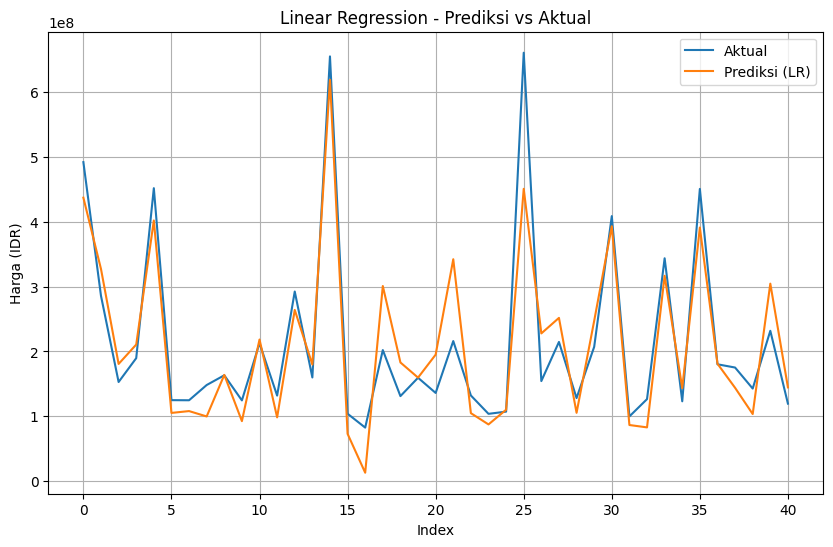

In [24]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Aktual")
plt.plot(y_pred_lr, label="Prediksi (LR)")
plt.title("Linear Regression - Prediksi vs Aktual")
plt.xlabel("Index")
plt.ylabel("Harga (IDR)")
plt.legend()
plt.grid(True)
plt.show()

## XGBoost Regressor

In [25]:
# Evaluasi Model
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("[XGBoost Regressor]")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R2 Score: {r2_xgb:.4f}")

[XGBoost Regressor]
MAE: 24761338.15
RMSE: 36498102.47
R2 Score: 0.9341


In [26]:
# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')

print("[XGBoost Regressor]")
print("Cross-Validation R2 per fold:", cv_scores_xgb)
print("Mean R2:", np.mean(cv_scores_xgb))

[XGBoost Regressor]
Cross-Validation R2 per fold: [0.93408544 0.89532026 0.91213925 0.92785038 0.93020461]
Mean R2: 0.9199199891046905


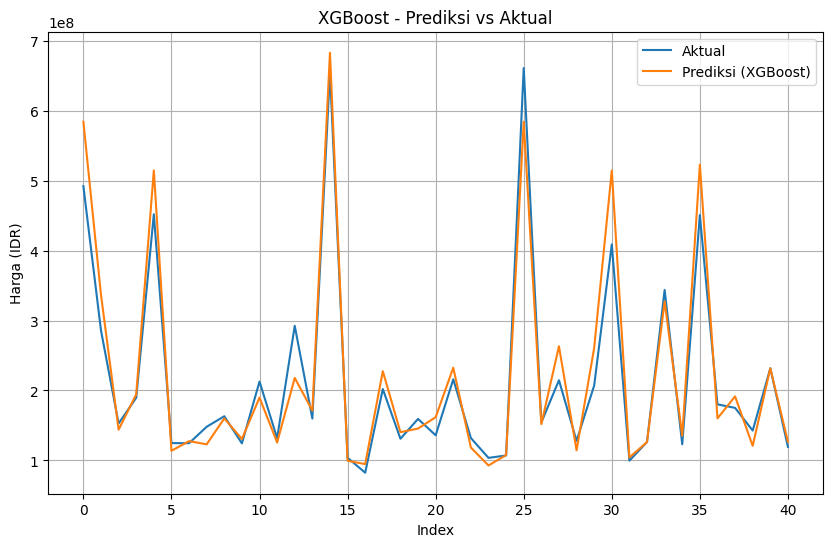

In [27]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Aktual")
plt.plot(y_pred_xgb, label="Prediksi (XGBoost)")
plt.title("XGBoost - Prediksi vs Aktual")
plt.xlabel("Index")
plt.ylabel("Harga (IDR)")
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Regressor

In [28]:
# Evaluasi Model
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("[Random Forest Regressor]")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2 Score: {r2_rf:.4f}")

[Random Forest Regressor]
MAE: 21351901.98
RMSE: 31172676.39
R2 Score: 0.9519


In [29]:
# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

print("[Random Forest Regressor]")
print("Cross-Validation R2 per fold:", cv_scores_rf)
print("Mean R2:", np.mean(cv_scores_rf))

[Random Forest Regressor]
Cross-Validation R2 per fold: [0.94745966 0.90406689 0.93244667 0.92564736 0.92445415]
Mean R2: 0.9268149464342861


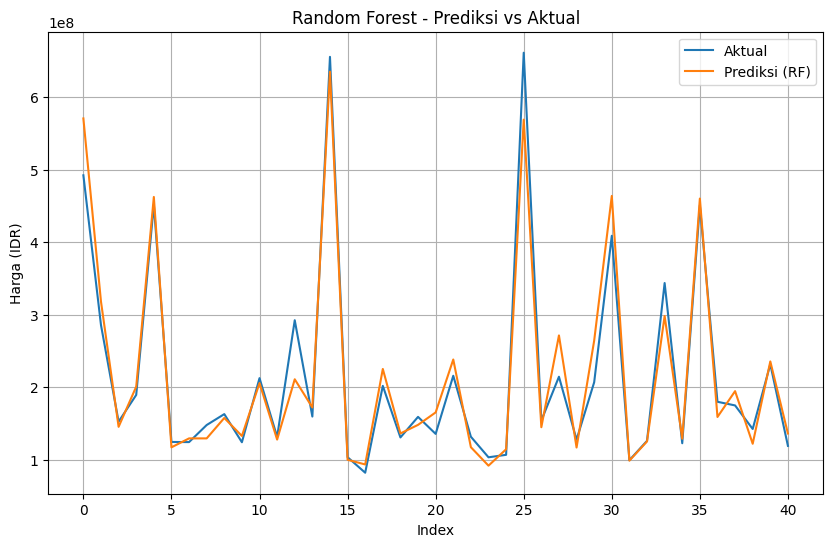

In [30]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Aktual")
plt.plot(y_pred_rf, label="Prediksi (RF)")
plt.title("Random Forest - Prediksi vs Aktual")
plt.xlabel("Index")
plt.ylabel("Harga (IDR)")
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Quantile Regressor

In [31]:
# Evaluasi Model
q_lower, q_median, q_upper = qrf_model.predict(X_test)

mae_qrf = mean_absolute_error(y_test, q_median)
rmse_qrf = np.sqrt(mean_squared_error(y_test, q_median))
r2_qrf = r2_score(y_test, q_median)

print("[Quantile RF]")
print(f"MAE: {mae_qrf:.2f}")
print(f"RMSE: {rmse_qrf:.2f}")
print(f"R2 Score: {r2_qrf:.4f}")

[Quantile RF]
MAE: 24676728.00
RMSE: 36341712.45
R2 Score: 0.9346


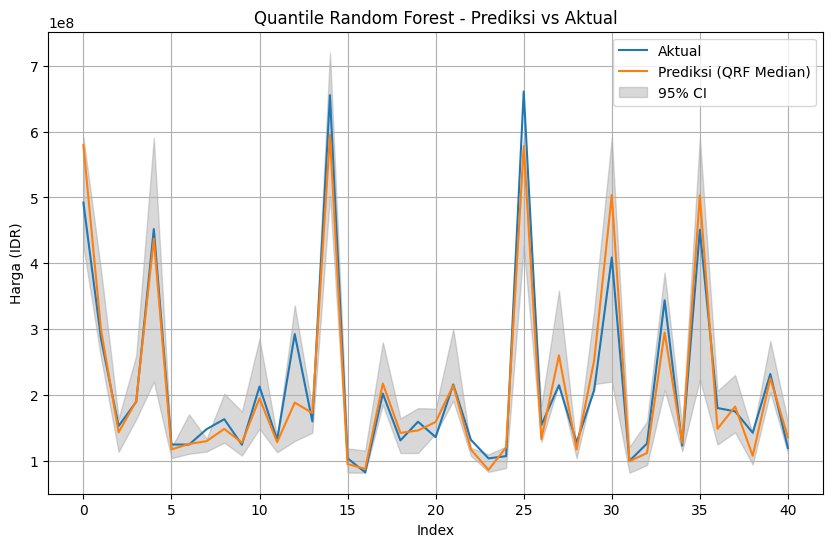

In [32]:
# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Aktual")
plt.plot(q_median, label="Prediksi (QRF Median)")
plt.fill_between(range(len(q_median)), q_lower, q_upper, color='gray', alpha=0.3, label="95% CI")
plt.title("Quantile Random Forest - Prediksi vs Aktual")
plt.xlabel("Index")
plt.ylabel("Harga (IDR)")
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [33]:
# Inference (Predict new data)
new_data = pd.DataFrame({
    'brand': [2],
    'wheelbase': [98.0],
    'carlength': [180.0],
    'carwidth': [66.5],
    'curbweight': [2500],
    'enginesize': [130],
    'fuelsystem': [0],
    'boreratio': [3.15],
    'horsepower': [111]
})

rf_exact = rf_model.predict(new_data)[0]
q_lower, q_median, q_upper = qrf_model.predict(new_data)

print("Prediksi Harga Mobil:")
print(f"Point Prediction (Exact):  Rp {rf_exact:,.2f}")
print(f"Lower Bound (2.5%):        Rp {q_lower[0]:,.2f}")
print(f"Median (50%):              Rp {q_median[0]:,.2f}")
print(f"Upper Bound (97.5%):       Rp {q_upper[0]:,.2f}")

Prediksi Harga Mobil:
Point Prediction (Exact):  Rp 237,666,190.48
Lower Bound (2.5%):        Rp 151,120,000.00
Median (50%):              Rp 242,082,736.00
Upper Bound (97.5%):       Rp 270,357,760.00
